# TSB Method for Intermittent Time Series Forecasting in NumPyro

In this notebook we provide a [`NumPyro`](http://num.pyro.ai) implementation of the TSB (Teunter, Syntetos and Babai) method for forecasting intermittent time series. The TSB method is similar to the [Croston's method](https://juanitorduz.github.io/croston_numpyro/) in the sense that is constructs two different time series out of the original one and then forecast each of them separately, so that the final forecast is generated by combining the forecasts of the two time series. The main difference between the two methods is that the TSB method uses the demand probability instead of the demand periods. Consequently,let $y_{t}$ denote the input time series then the TSB method is specified by the following equations:

If $y_{t} > 0$, then

$$
\begin{align*}
z_{t + 1} & = \alpha y_{t} + (1 - \alpha) z_{t} \\
p_{t + 1} & = \beta + (1 - \beta) p_{t}
\end{align*}
$$

If $y_{t} = 0$, then

$$
\begin{align*}
z_{t + 1} & = z_{t} \\
p_{t + 1} & = (1 - \beta) p_{t}
\end{align*}
$$

where $z_{t}$ is the demand (level) of the time series at time $t$, $p_{t}$ is the probability of observing a non-zero demand at time $t$, and $\alpha$ and $\beta$ are the smoothing parameters. The forecast is then given by the product.

$$
\hat{y}_{t + 1} = z_{t} p_{t}
$$

For many applications, the TSB method is more appropriate than the Croston's method, sine the predictions will be updated at eah each time period, even if the demand is zero. Recall that in the Croston's method, the forecast is only updated when the demand is non-zero. We will illustrate this at the end of the notebook.

For more details and model comparison, see these two nice references:
- [Adaptations of Croston's Method](https://www.pmorgan.com.au/tutorials/adaptations-of-crostons-method/)
- [StatsForecast documentation on the TSB model](https://nixtlaverse.nixtla.io/statsforecast/docs/models/tsb.html)

---

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import pandas as pd
import preliz as pz
import xarray as xr
from jax import random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsforecast import StatsForecast
from statsforecast.models import CrostonOptimized, TSB
from statsforecast.utils import ConformalIntervals
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

---

## Generate Synthetic Data

We consider thee same synthetic data as in the previous post [Croston's Method for Intermittent Time Series Forecasting in NumPyro](https://juanitorduz.github.io/croston_numpyro/):

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

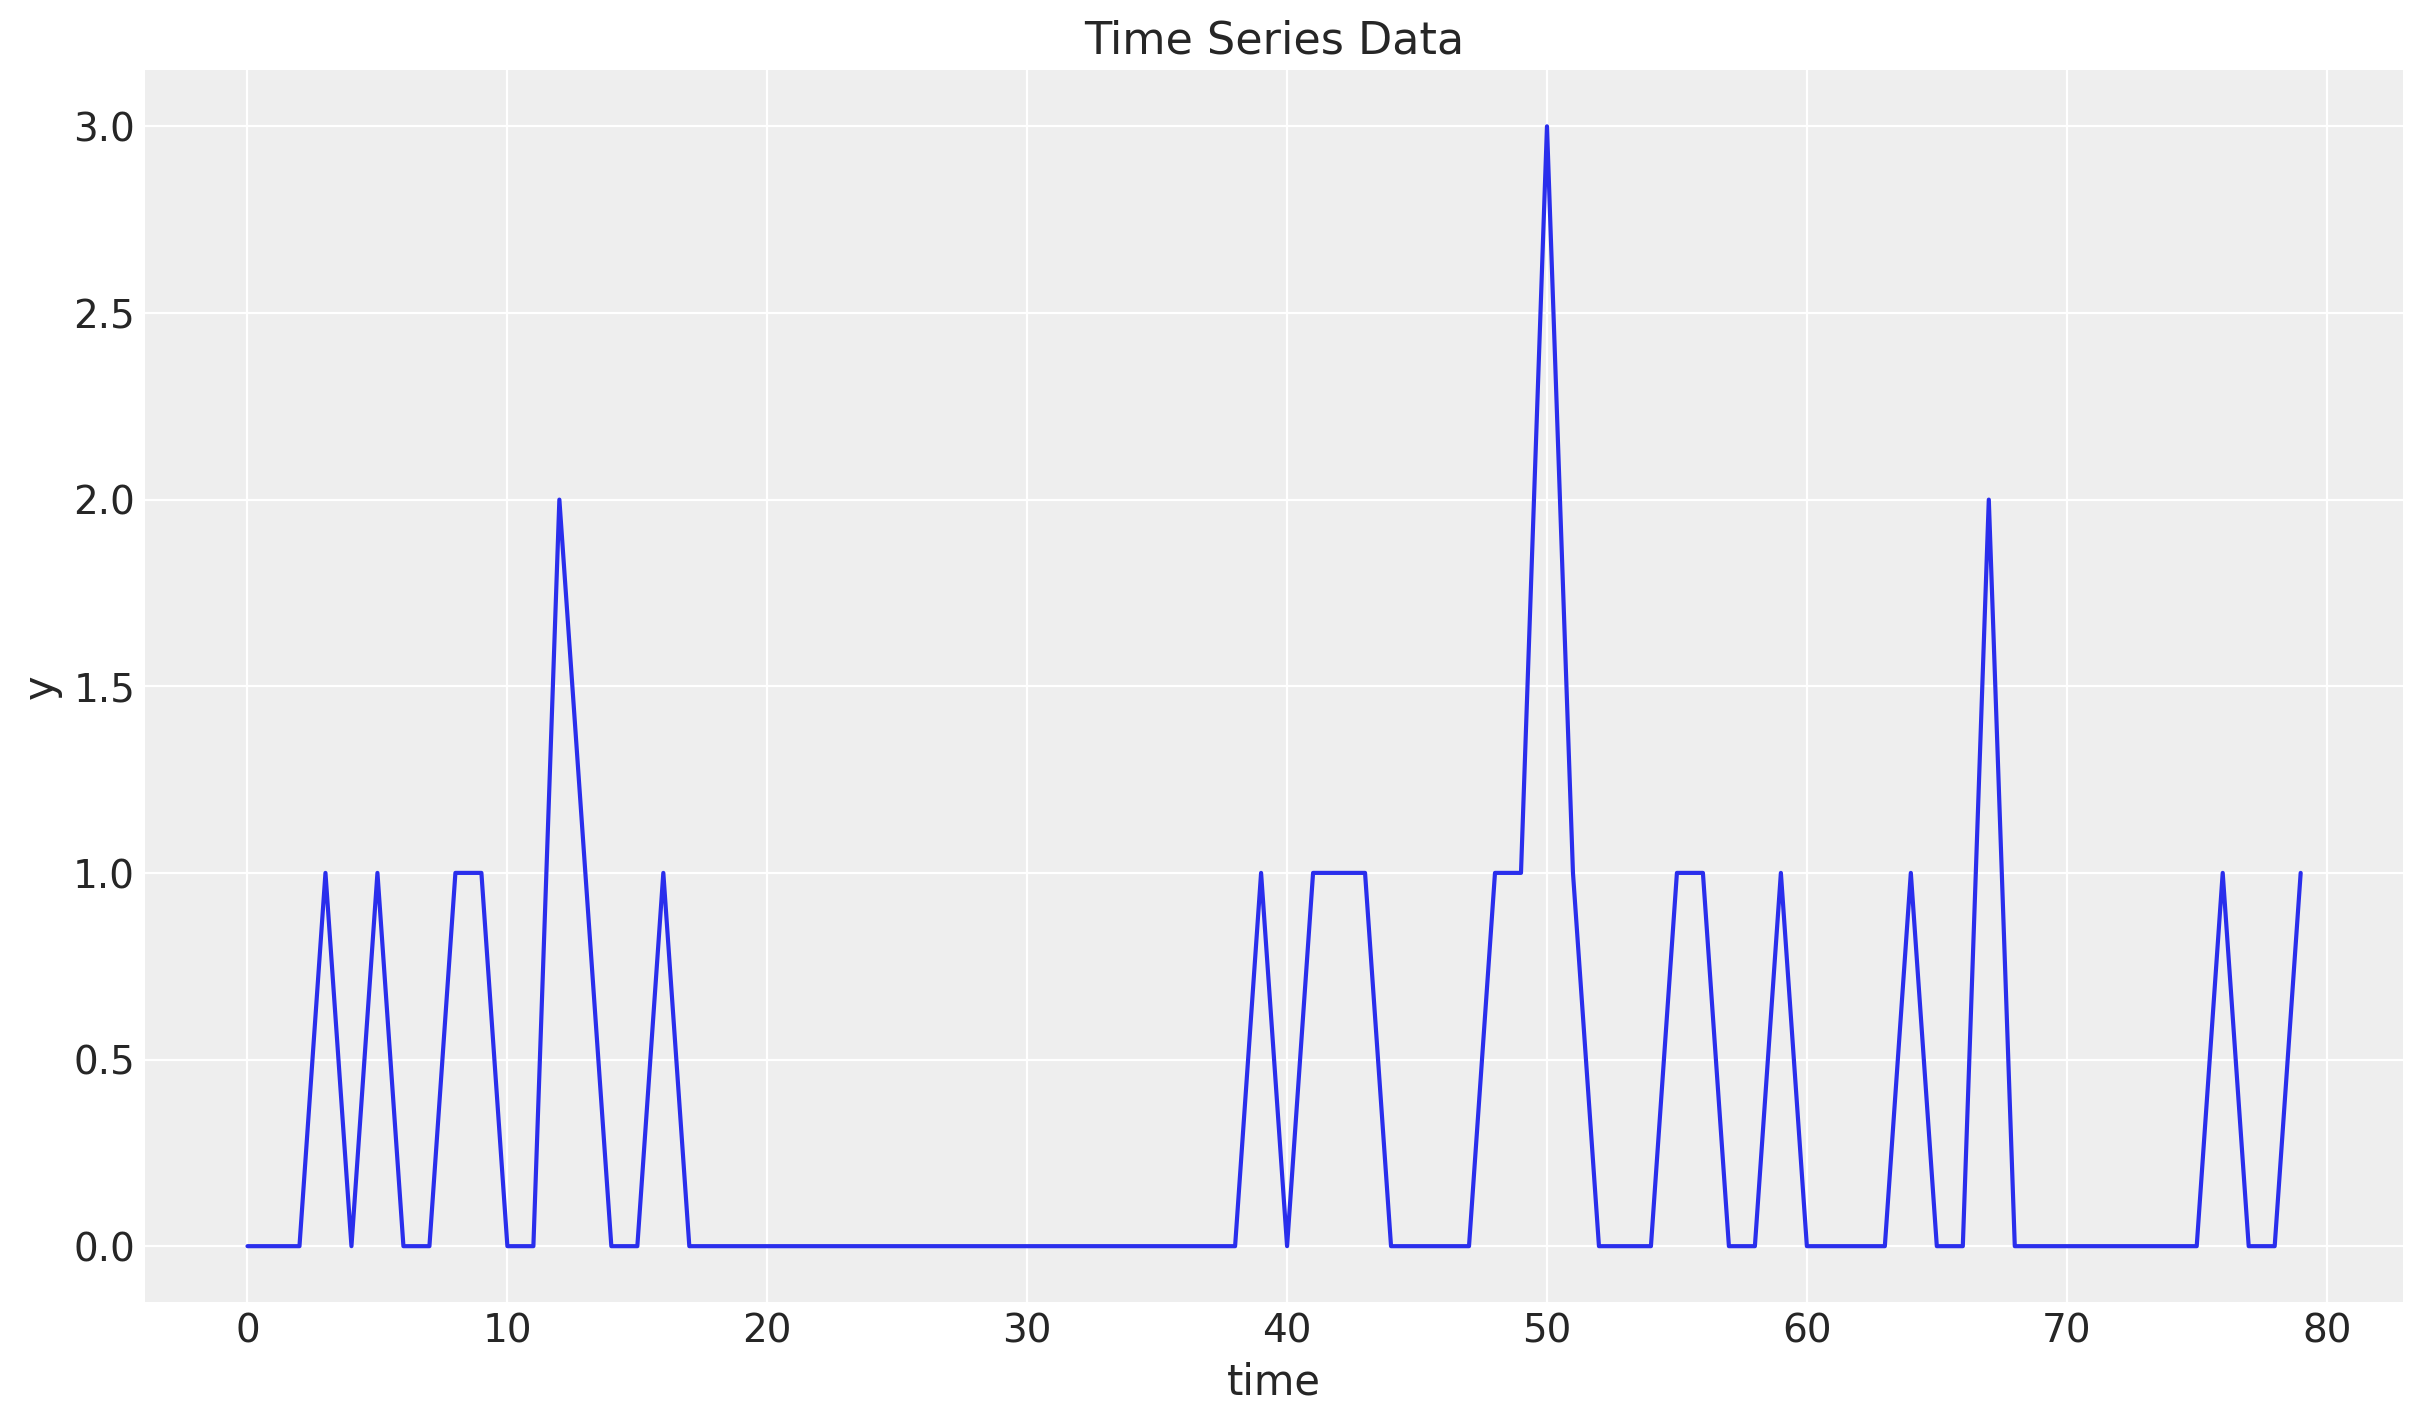

In [2]:
n = 80
lam = 0.3

y = random.poisson(key=rng_key, lam=lam, shape=(n,)).astype(jnp.float32)
t = jnp.arange(y.size)

fig, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

---

## Train-Test Split

Similarly as before we do a simple train-test split.

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

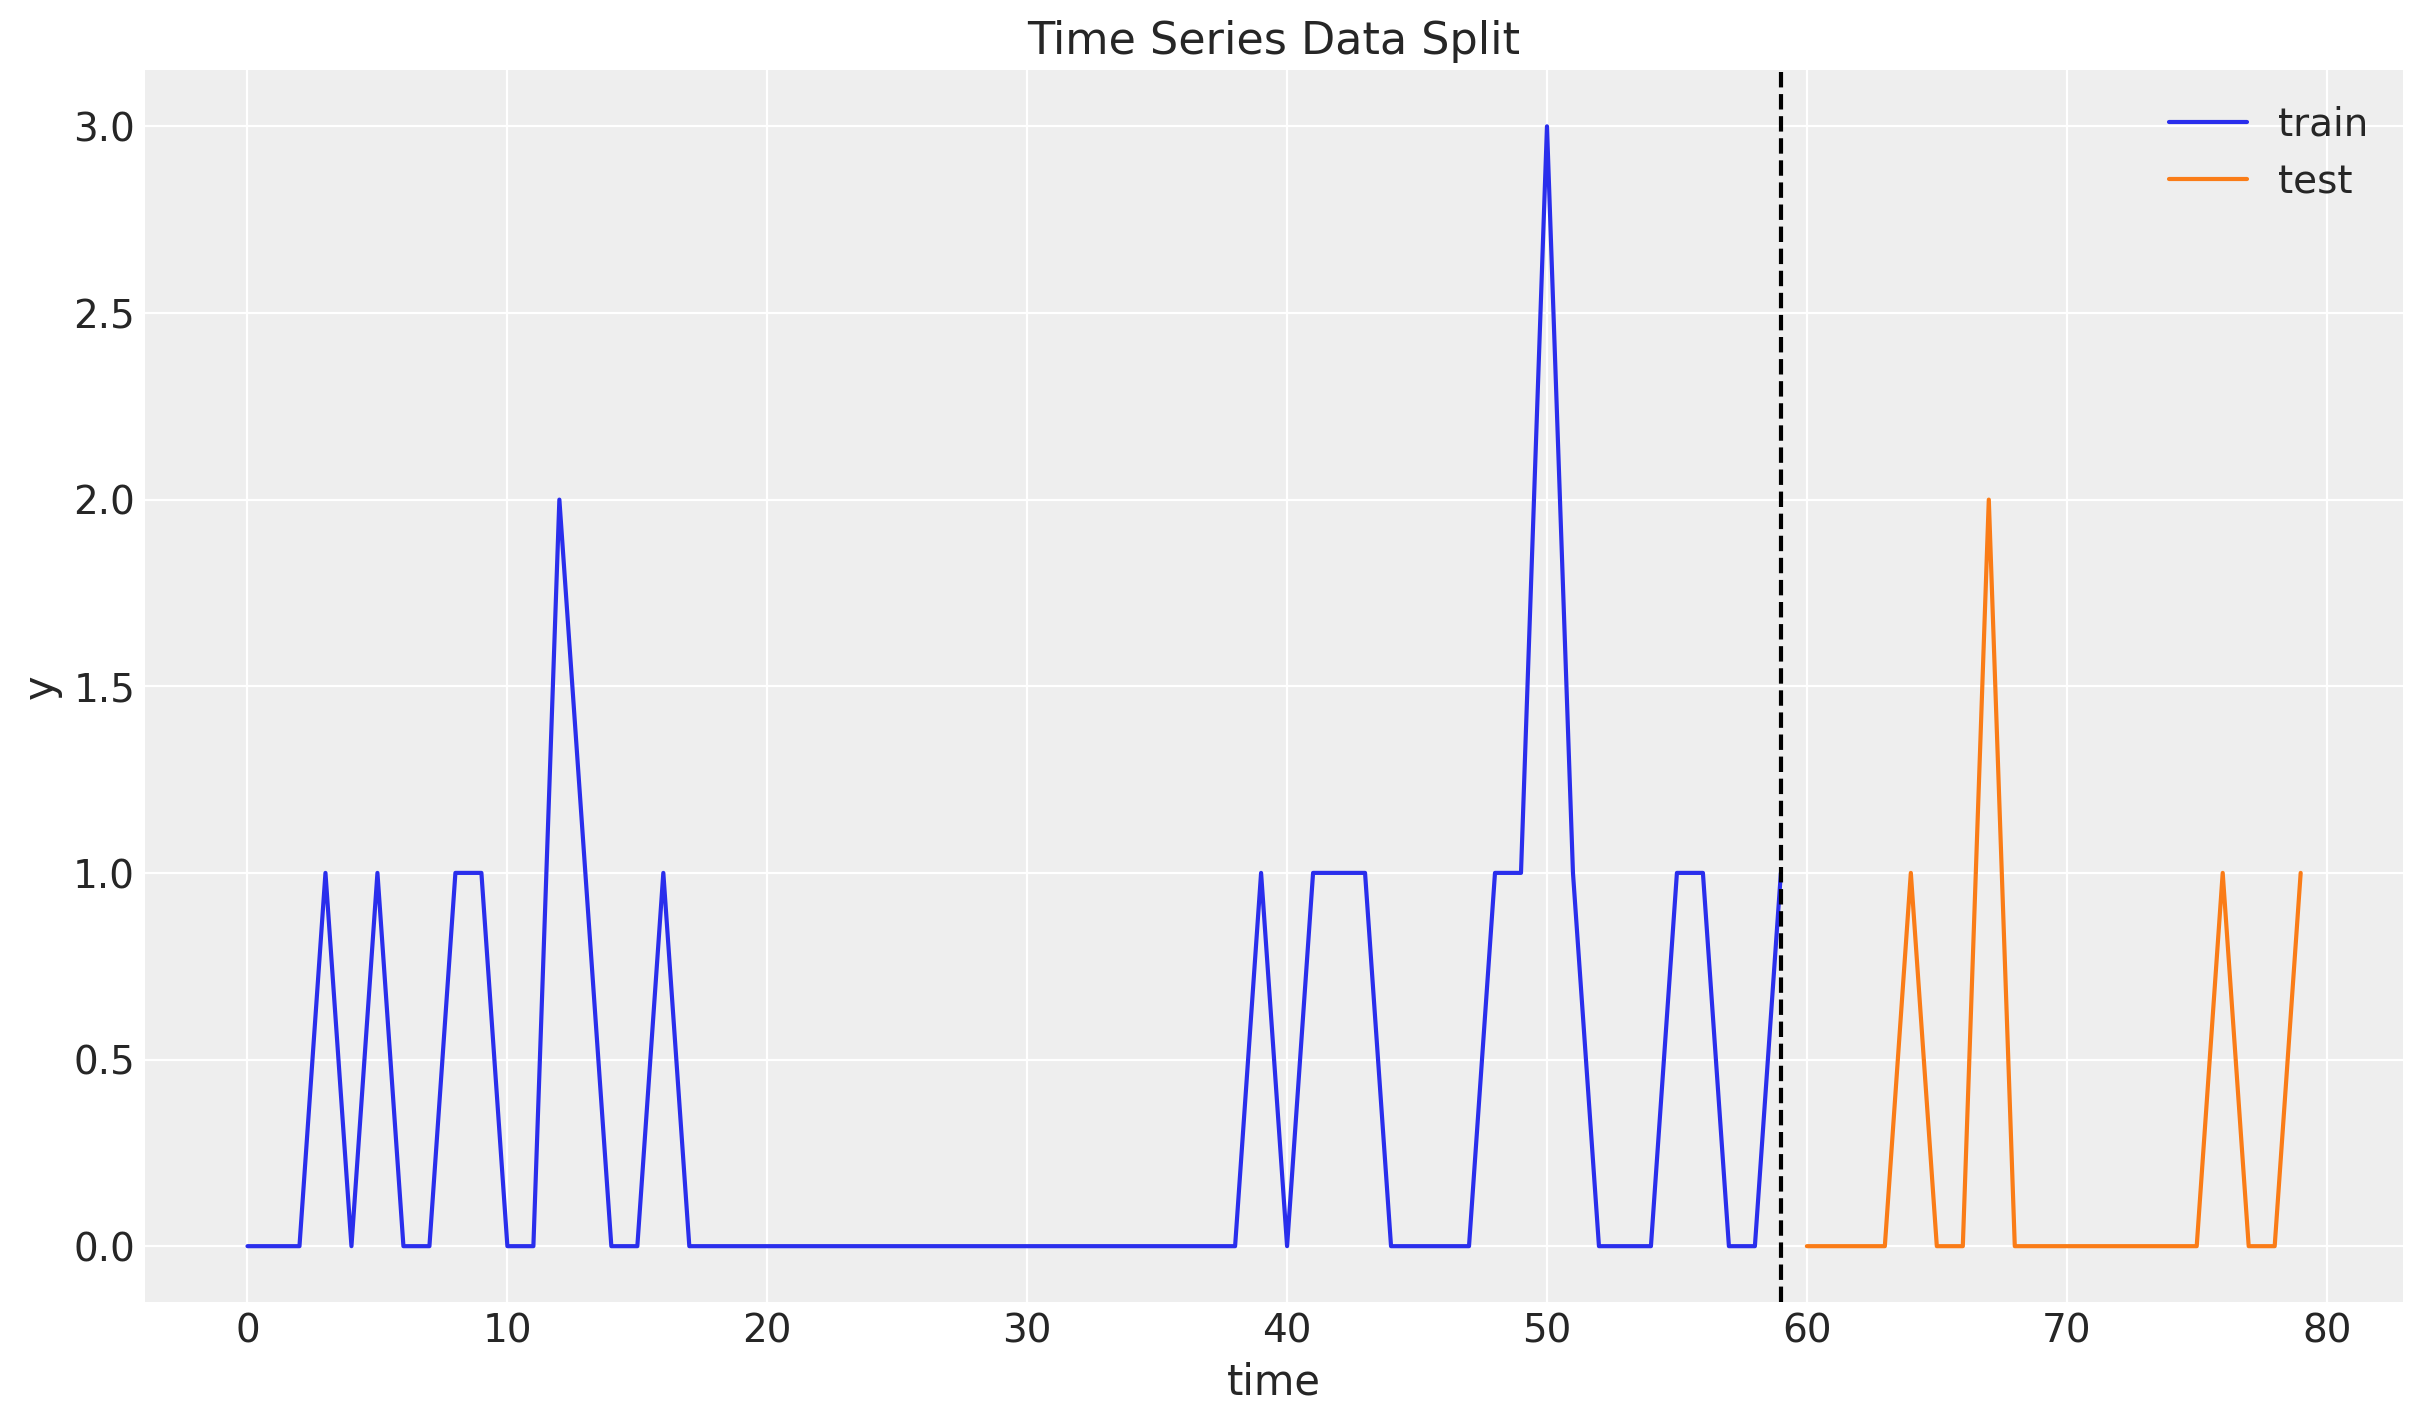

In [87]:
n = y.size

prop_train = 0.85
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

---

## TSB Model with StatsForecast

Again, we first generate forecasts for the TSB model using the [`statsforecast`](https://nixtlaverse.nixtla.io/statsforecast/index.html) package. The model requires the the user to provide the smoothing parameters $\alpha$ and $\beta$ (which could be estimatd via time-slice cross-validation). We choose certain values which will be explained later. For now, just take them as given.

In [88]:
sf = StatsForecast(
    models=[CrostonOptimized(), TSB(alpha_d=0.311, alpha_p=0.57)],
    freq=1,
    n_jobs=-1,
)

train_df = pd.DataFrame({"unique_id": "a", "ds": t_train, "y": y_train})

sf_forecast = sf.forecast(
    h=y_test.size,
    df=train_df,
    level=[94],
    prediction_intervals=ConformalIntervals(n_windows=5),
)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


For this specific smoothing parameters the forecast in significantly higher then the Croston's method. The reason is that at the enf of the training set we have a big spike. As we will see at the end, this forecast will decay as the training set increases with zero values.

---

## TSB Model with NumPyro

The NumPyro implementation of the TSB model follows very closely the mathematical specification of the model. As in many other time series model, we rely on the [`scan`](https://num.pyro.ai/en/stable/primitives.html#scan) primitive to implement the recursive formulas. For an introduction to the `scan` primitive, see the first part of the notebook [Notes on Exponential Smoothing with NumPyro](https://juanitorduz.github.io/exponential_smoothing_numpyro/).

### Prior Specification

One key component of the model is the prior distribution for the smoothing parameters. In principle, $\alpha$ and $\beta$ could be any value between 0 and 1. However, in practice, it is common to restrict the values to be between $[0.05, 0.4]$. I have seen this helps the sampling considerably. For this example, we take the following prior distribution:

[Text(0.5, 1.0, 'Beta(10, 40) PDF'), Text(0.5, 0, '$\\alpha$')]

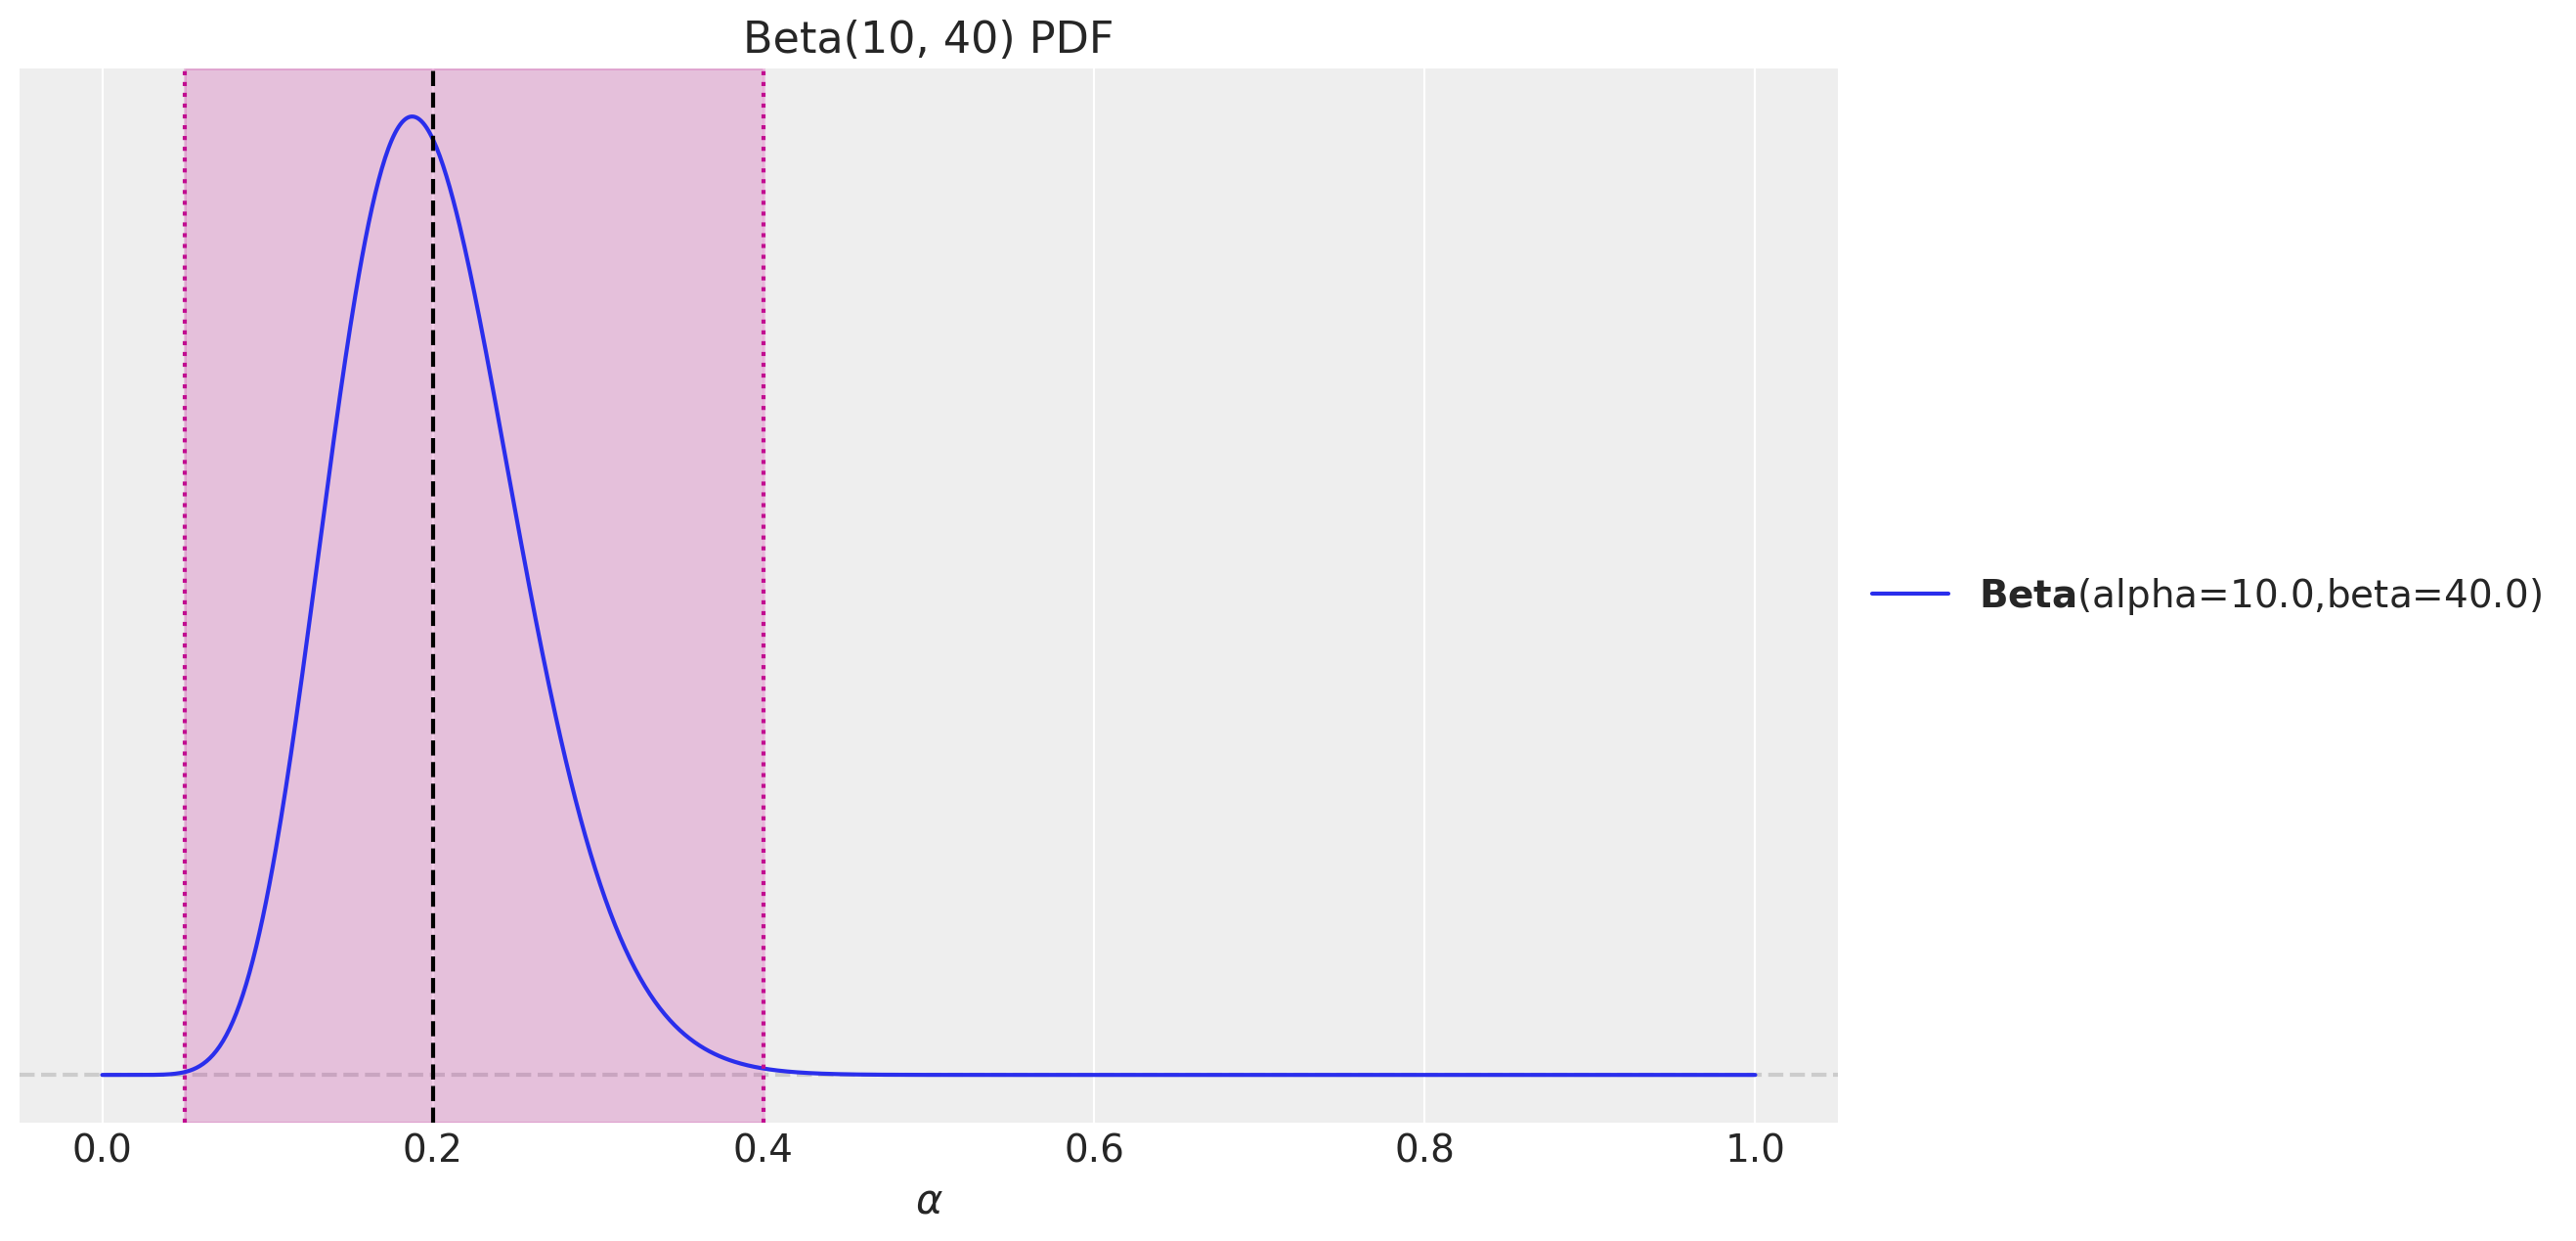

In [89]:
fig, ax = plt.subplots()
pz.Beta(10, 40).plot_pdf(ax=ax)
ax.axvline(x=(10 / (40 + 10)), c="black", linestyle="--")  # mean
ax.axvline(x=0.05, c="C3", linestyle=":")  # lower bound
ax.axvline(x=0.4, c="C3", linestyle=":")  # upper bound
ax.axvspan(xmin=0.05, xmax=0.4, color="C3", alpha=0.2)
ax.set(title="Beta(10, 40) PDF", xlabel="$\\alpha$")

### Model Specification

The model is specified is very close to the mathematical formulation. The key component is to implement the transition functions. We follow the description given in the blog post [Adaptations of Croston's Method](https://www.pmorgan.com.au/tutorials/adaptations-of-crostons-method/). Note that for the model we trim the zero values at the beginning at the time series. We also need to provide the initial points fot the demand and the probability. We take the first non-zero value for the demand and the mean of the non-zero values for the probability. For the demand is first non-zero demand value while for the probability is the inverse of thee mean of all demand intervals.

In [90]:
def get_model_args(y_train: ArrayImpl) -> tuple[ArrayImpl, float, float]:
    y_train_trim = jnp.trim_zeros(y_train, trim="f")
    p_idx = jnp.flatnonzero(y_train)
    p_diff = jnp.diff(p_idx, prepend=-1)
    z0 = y_train[p_idx[0]]
    p0 = 1 / p_diff.mean()
    return y_train_trim, z0, p0


y_train_trim, z0, p0 = get_model_args(y_train)

Next, we specify the NumPyro model:

In [91]:
def tsb_model(ts_trim: ArrayImpl, z0: float, p0: float, future: int = 0) -> None:
    t_max_trim = ts_trim.size

    # --- Priors ---

    z_smoothing = numpyro.sample(
        "z_smoothing", dist.Beta(concentration1=2, concentration0=2)
    )
    p_smoothing = numpyro.sample(
        "p_smoothing", dist.Beta(concentration1=2, concentration0=20)
    )
    concentration = numpyro.sample("concentration", dist.HalfNormal(scale=1))

    # --- Transition Function ---

    def transition_fn(carry, t):
        z_prev, p_prev = carry

        z_next = jnp.where(
            t < t_max_trim,
            jnp.where(
                ts_trim[t] > 0,
                z_smoothing * ts_trim[t] + (1 - z_smoothing) * z_prev,
                z_prev,
            ),
            z_prev,
        )

        p_next = jnp.where(
            t < t_max_trim,
            jnp.where(
                ts_trim[t] > 0,
                p_smoothing + (1 - p_smoothing) * p_prev,
                (1 - p_smoothing) * p_prev,
            ),
            p_prev,
        )

        mu = z_next * p_next
        pred = numpyro.sample(
            "pred",
            dist.ZeroInflatedNegativeBinomial2(
                mean=mu, concentration=concentration, gate=p_next
            ),
        )

        return (z_next, p_next), pred

    # --- Run Scan ---

    with numpyro.handlers.condition(data={"pred": ts_trim}):
        _, preds = scan(
            transition_fn,
            (z0, p0),
            jnp.arange(t_max_trim + future),
        )

    # --- Forecast ---

    if future > 0:
        return numpyro.deterministic("ts_forecast", preds[-future:])
    return None

### Inference

We now fit the model:

In [92]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [93]:
inference_params = InferenceParams()

rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, tsb_model, inference_params, y_train_trim, z0, p0)

idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
concentration,1.707,0.600,0.669,2.820,0.007,0.005,6572.0,4534.0,1.0
p_smoothing,0.105,0.054,0.009,0.198,0.001,0.000,4390.0,2788.0,1.0
z_smoothing,0.588,0.217,0.201,0.967,0.003,0.002,6602.0,4786.0,1.0


All diagnostics look good:

In [94]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'TSB Model Trace')

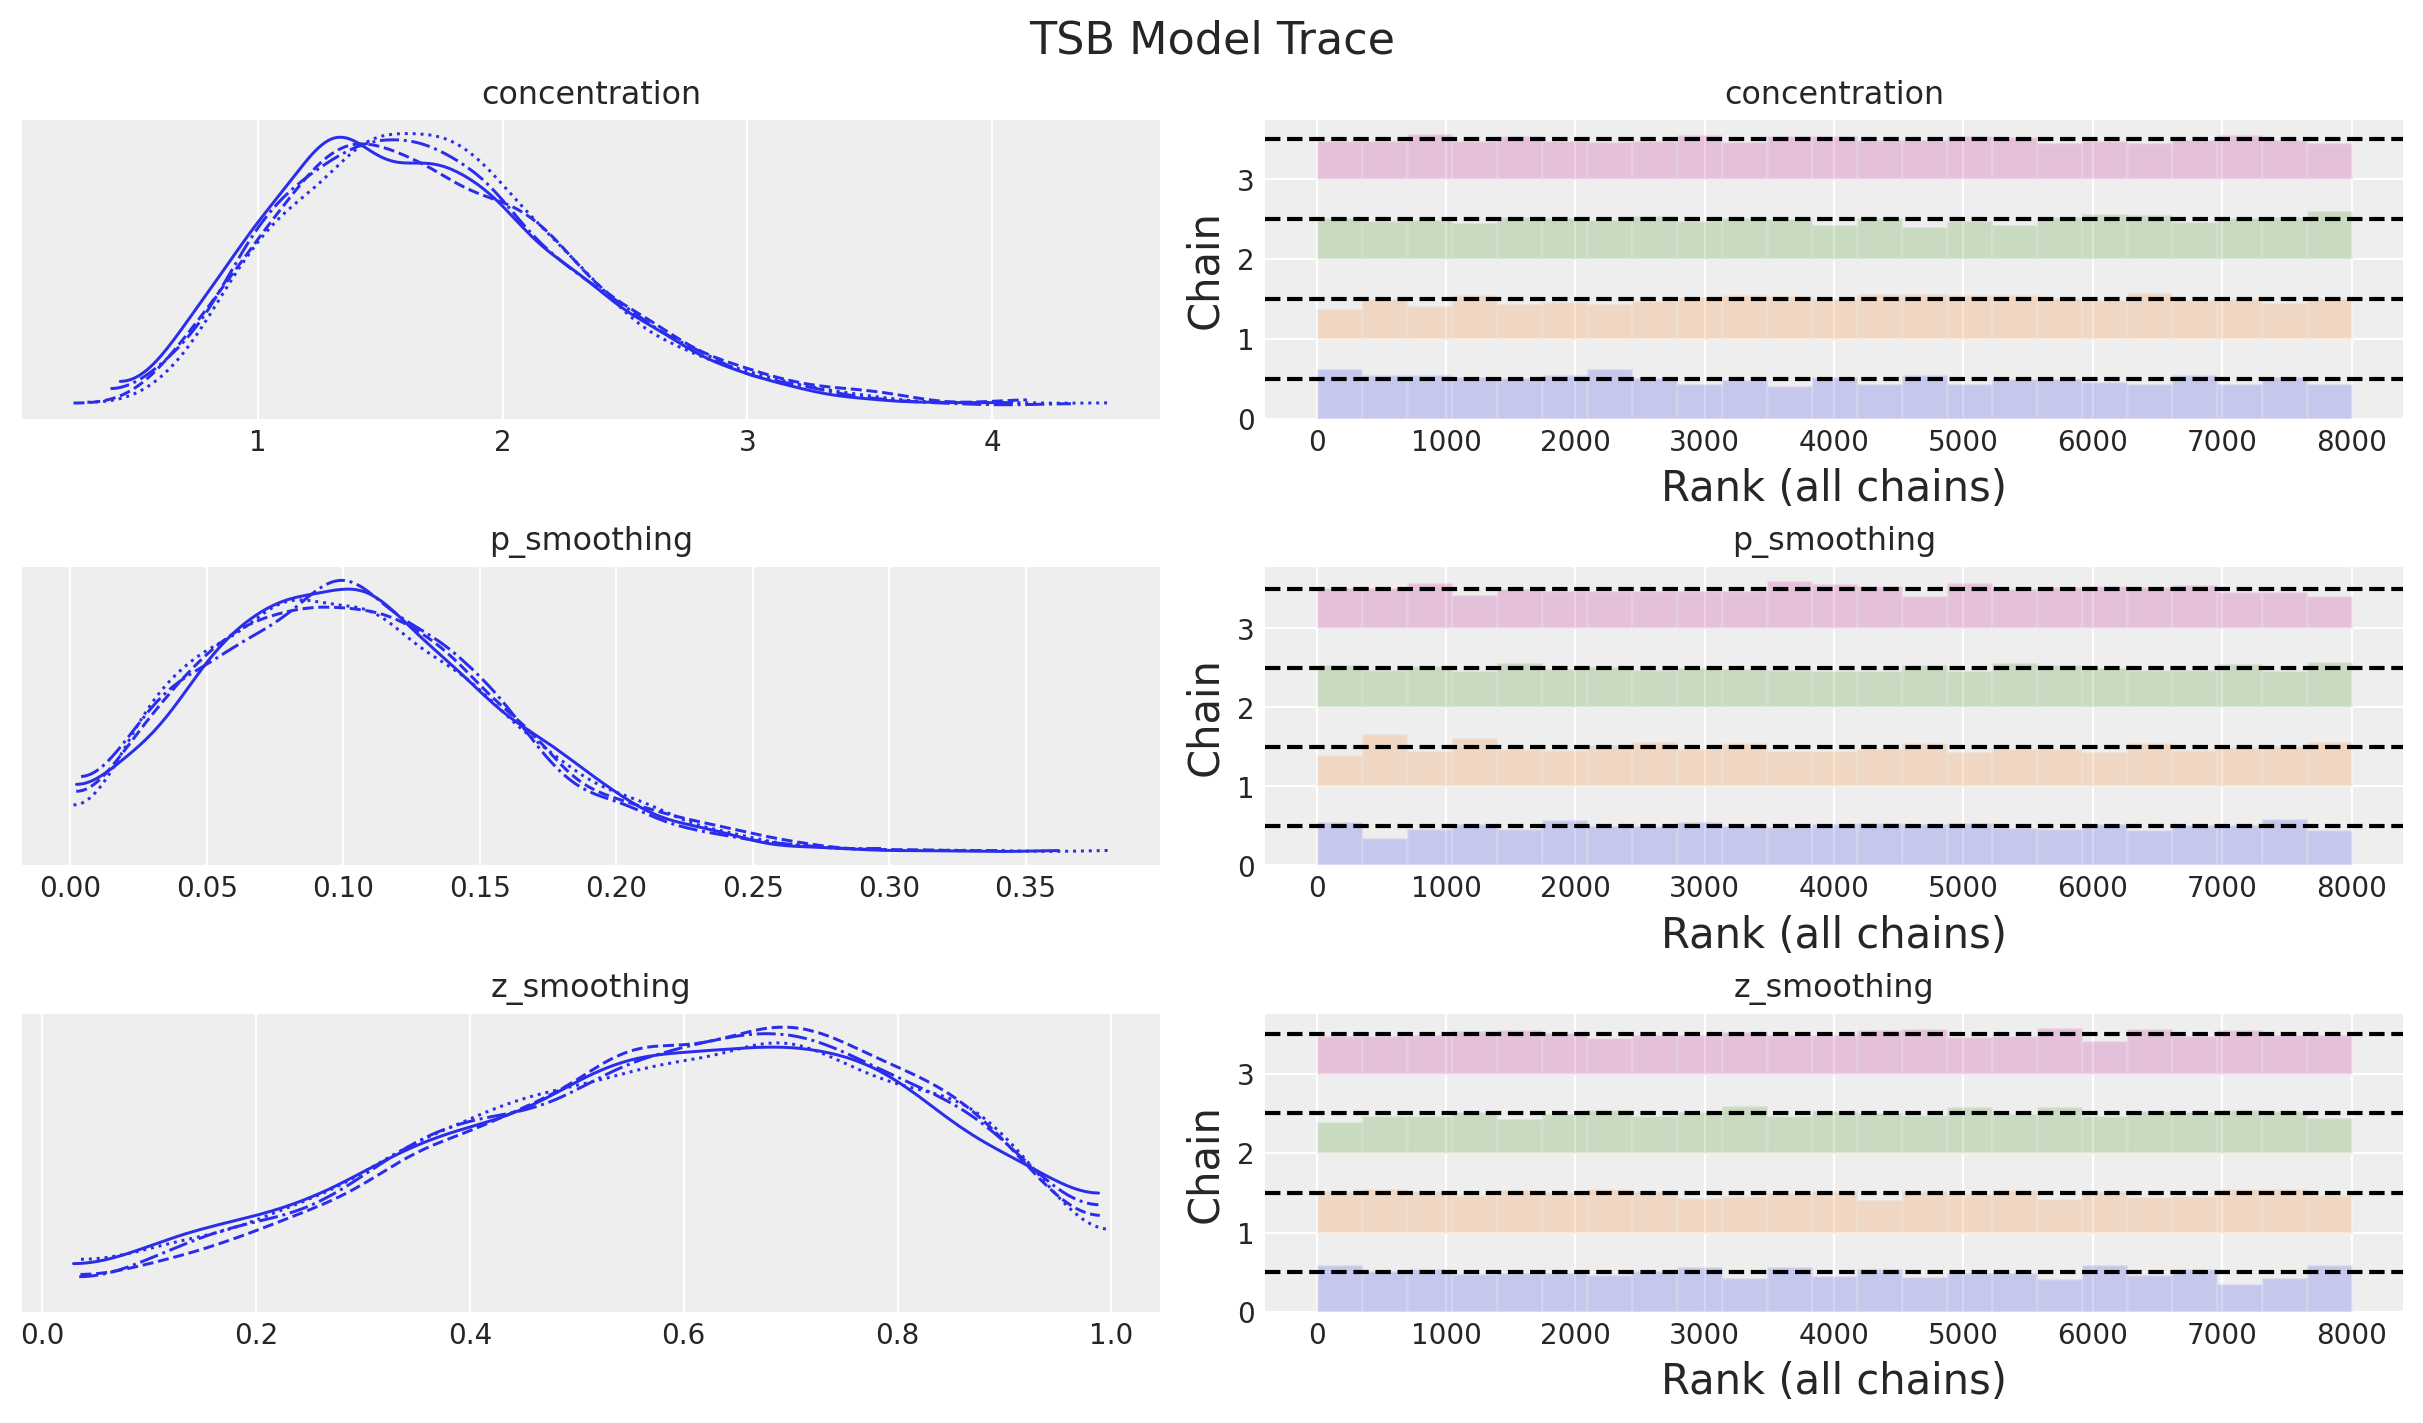

In [95]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("TSB Model Trace", fontsize=16)

It is worth noting that the posterior distribution of the smoothing parameters between the demand size and the probabilities are different.

**Remark:** Note that the smoothing parameters chosen in the `statsforecast` model are precisely the posterior means of the NumPyro model. This is just for the sake of comparison.

### Forecast

We now generate the forecast:

In [96]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["ts_forecast"],
    )
    return predictive(rng_key, *model_args)

In [97]:
rng_key, rng_subkey = random.split(key=rng_key)
tsb_forecast = forecast(
    rng_subkey,
    tsb_model,
    mcmc.get_samples(),
    y_train_trim.astype(jnp.int32),
    z0,
    p0,
    y_test.size,
)

posterior_predictive = az.from_numpyro(
    posterior_predictive=tsb_forecast,
    coords={"t": t_test},
    dims={"ts_forecast": ["t"]},
)

Let's see the result and compare it with the `statsforecast` model:

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'TSB Model Forecast')]

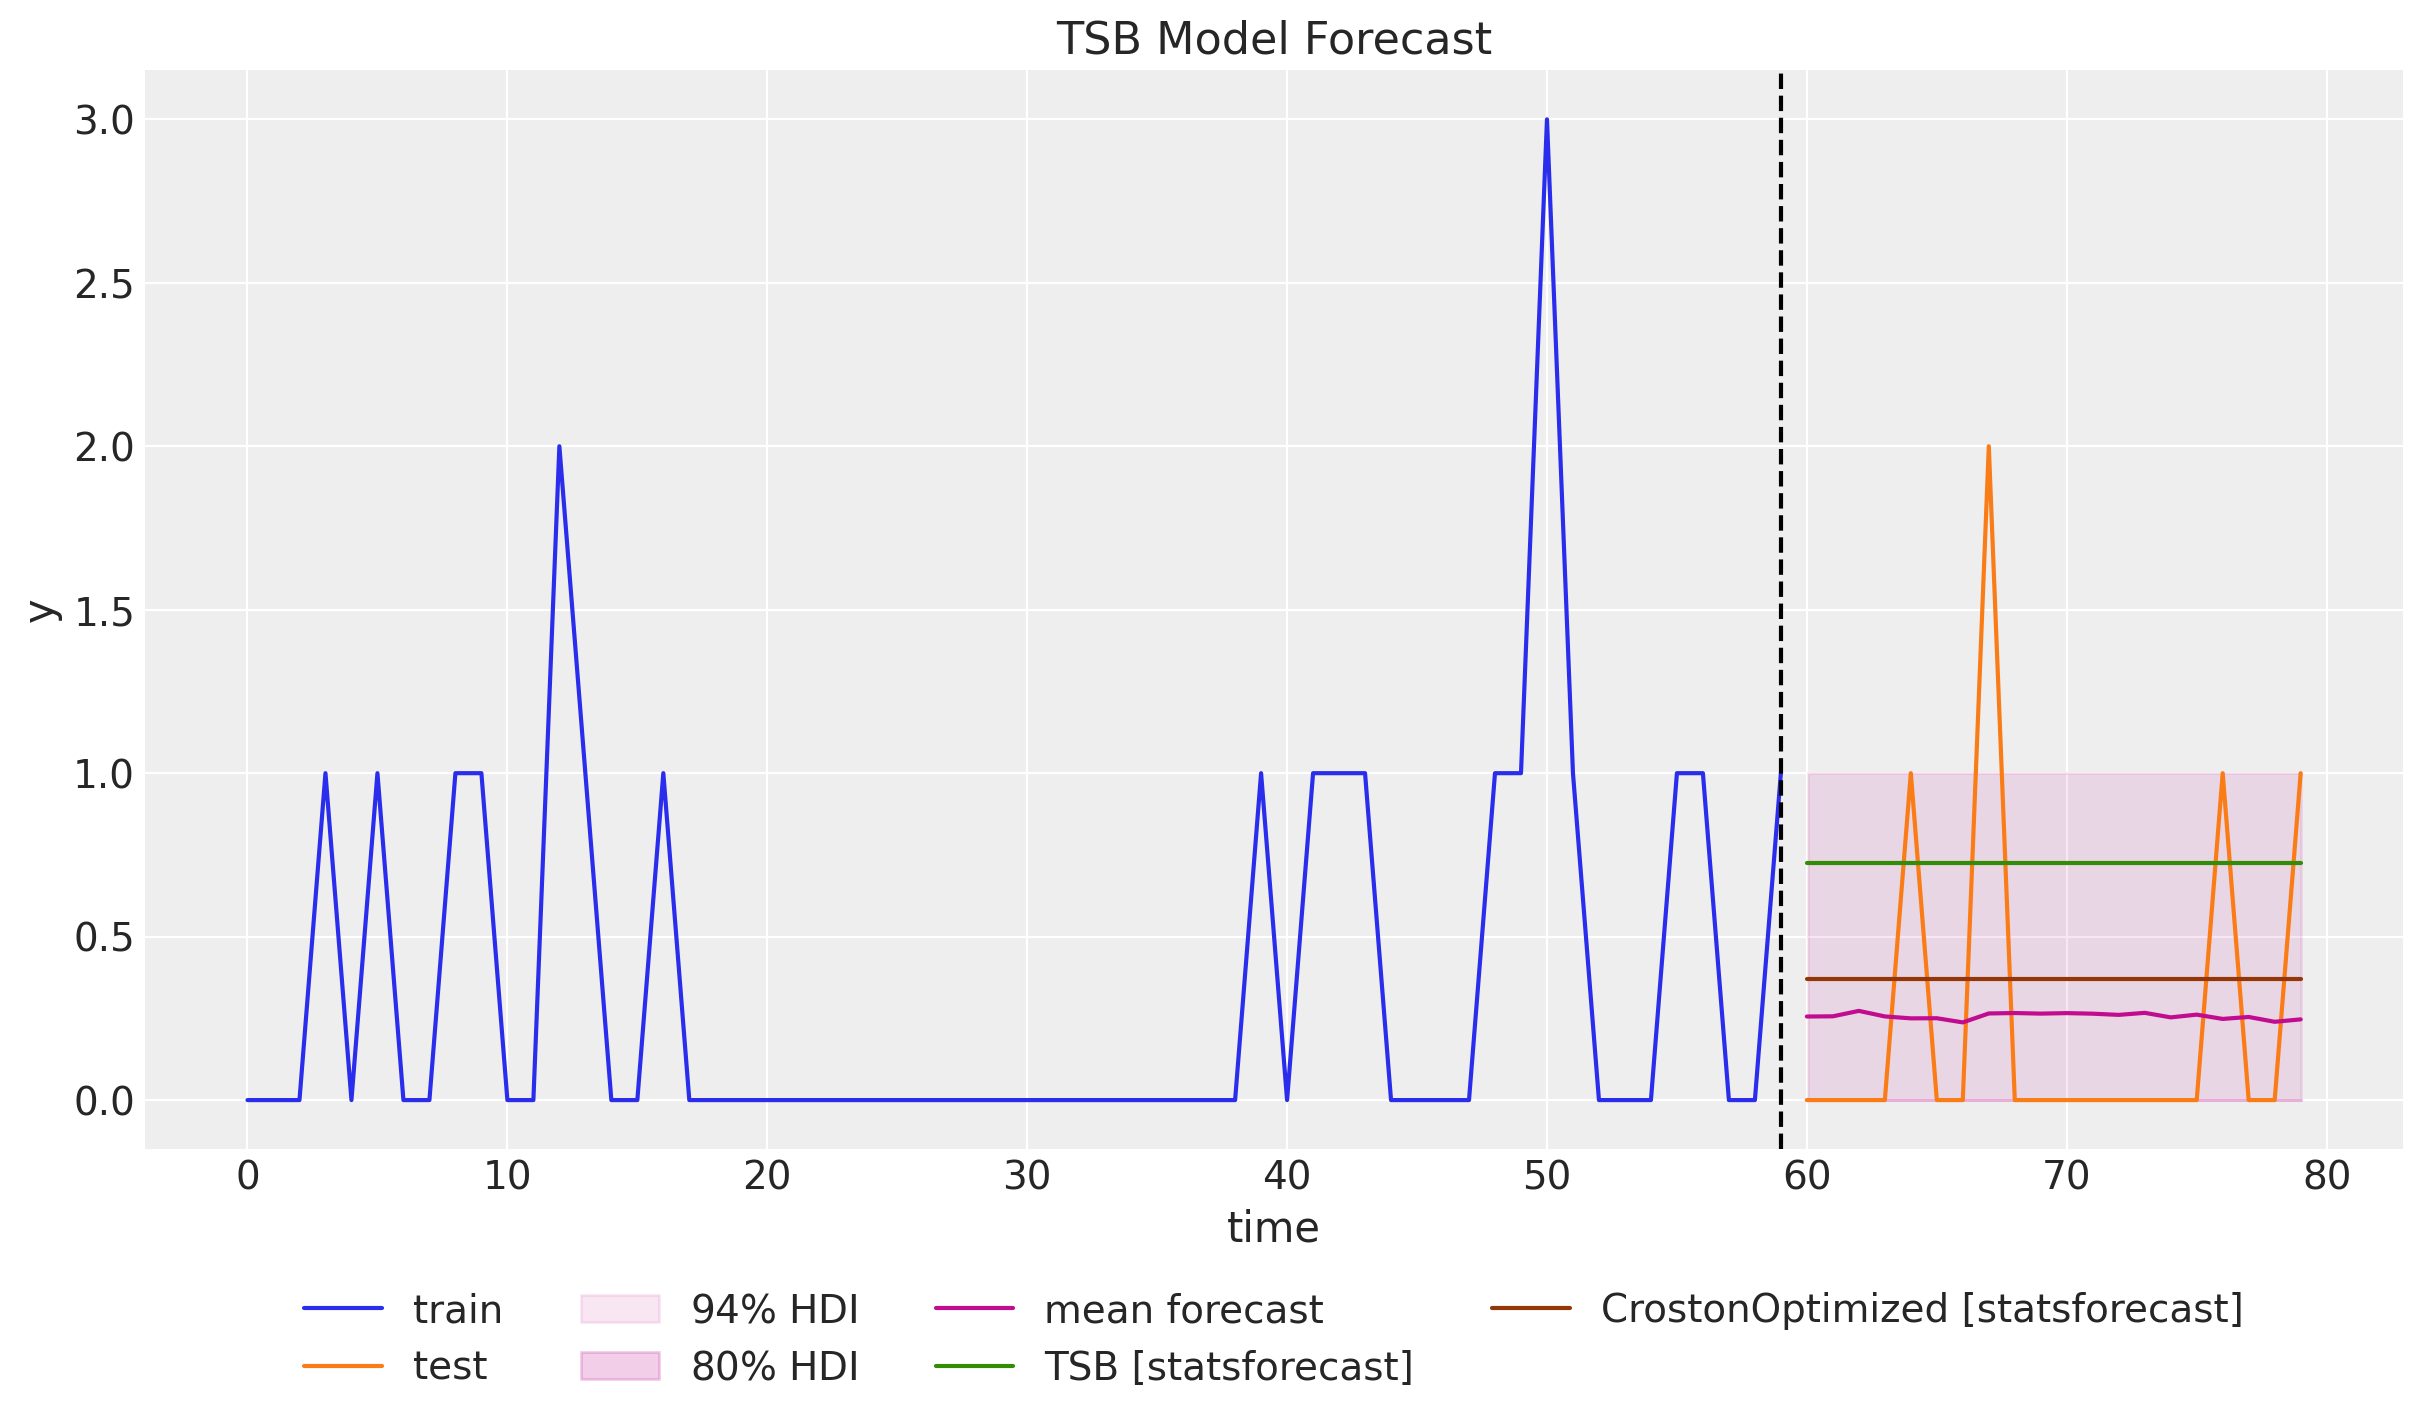

In [98]:
fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["ts_forecast"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.1, "label": "$94\\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["ts_forecast"],
    hdi_prob=0.80,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": "$80\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["ts_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_test, sf_forecast["TSB"], color="C2", label="TSB [statsforecast]")
ax.plot(
    t_test,
    sf_forecast["CrostonOptimized"],
    color="C4",
    label="CrostonOptimized [statsforecast]",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y", title="TSB Model Forecast")

<Axes: title={'center': 'ts_forecast'}>

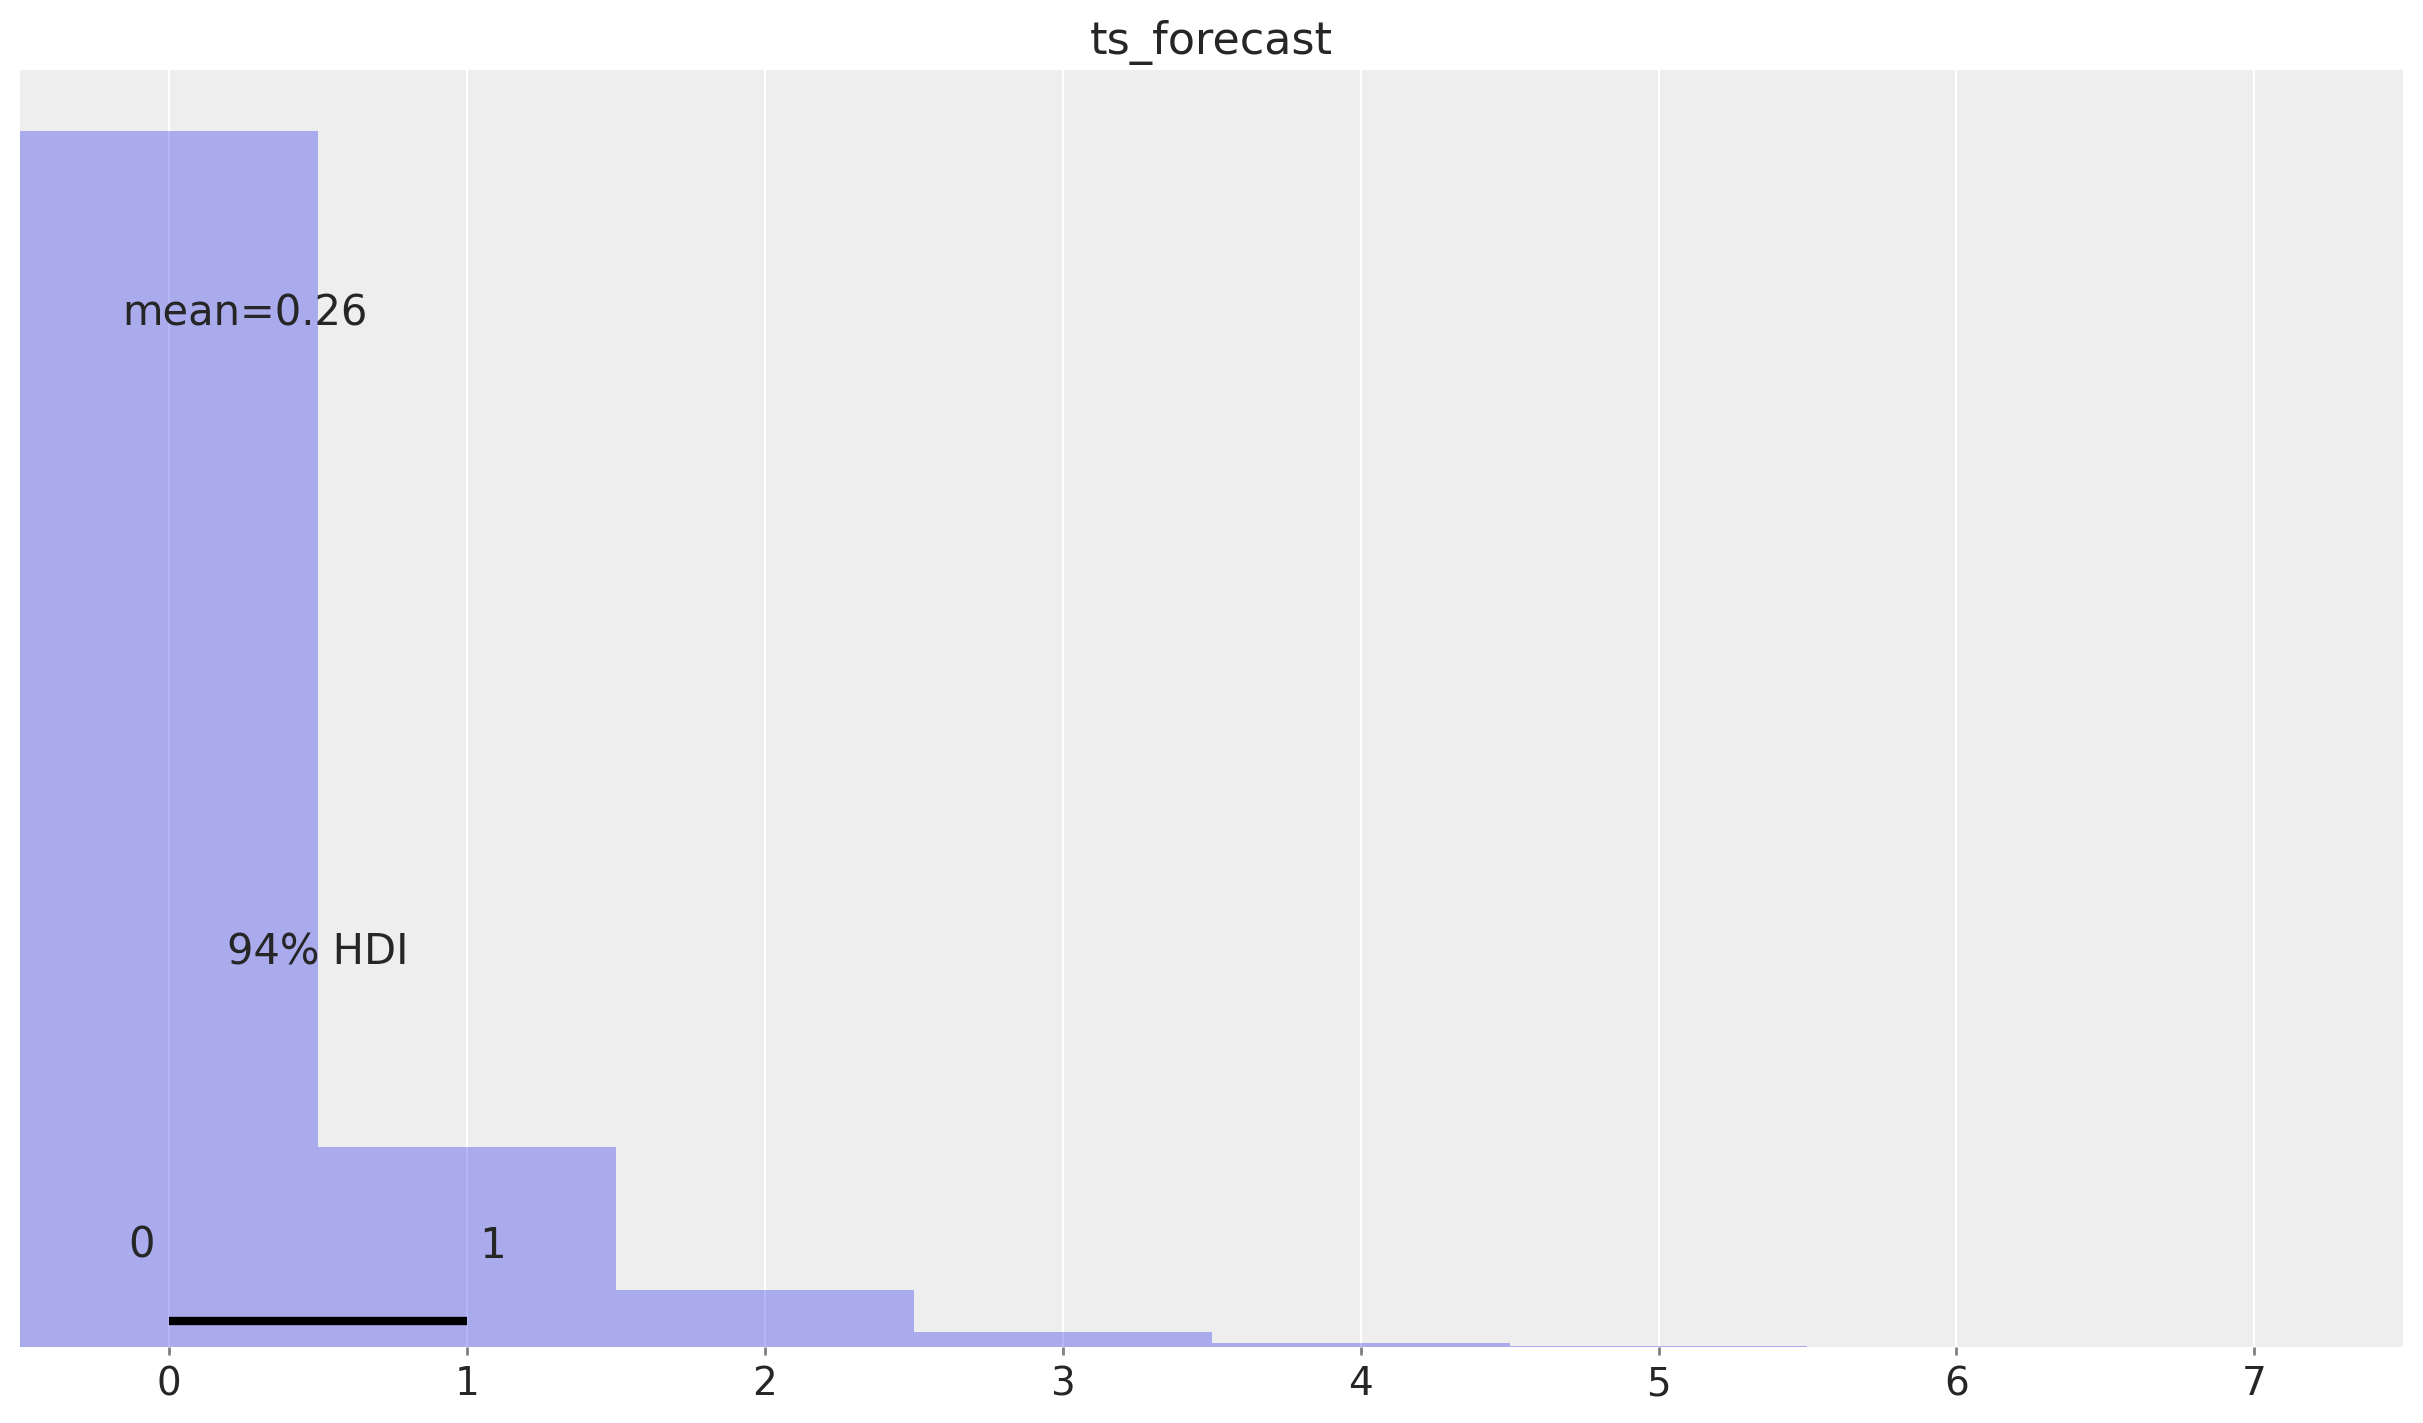

In [99]:
az.plot_posterior(
    data=posterior_predictive["posterior_predictive"]["ts_forecast"].sel(t=n_train)
)

The point forecast matches the `statsforecast` model. The uncertainty is also very similar of the NumPyro model is narrower than the confidence intervals generated by the `statsforecast` model using conformal prediction. Once concerning aspect is that the $94\\%$ HDI does not contain zero 🤔.

---

## Time Slice Cross Validation

Now we deep dive into the TSB property of updating the forecast even when the demand is zero. We write a custom time-slice cross validation to generate one step ahead forecasts.

In [100]:
def tsb_time_slice_cross_validation(
    rng_key: ArrayImpl, y: ArrayImpl, n_splits: int, inference_params: InferenceParams
) -> xr.Dataset:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        # Prepare data
        y_train = y[: -(n_splits - i)]
        y_train_trim, z0, p0 = get_model_args(y_train)
        # Inference
        rng_key, rng_subkey = random.split(key=rng_key)
        mcmc = run_inference(
            rng_subkey,
            tsb_model,
            inference_params,
            y_train_trim,
            z0,
            p0,
        )
        # Forecast
        rng_key, rng_subkey = random.split(key=rng_key)
        tsb_forecast = forecast(
            rng_subkey,
            tsb_model,
            mcmc.get_samples(),
            y_train_trim.astype(jnp.int32),
            z0,
            p0,
            1,
        )
        forecast_list.append(
            az.from_numpyro(
                posterior_predictive=tsb_forecast,
                coords={"t": [y_train_trim.size]},
                dims={"ts_forecast": ["t"]},
            )
        )
    # Concatenate forecasts
    return xr.concat(
        [x["posterior_predictive"] for x in forecast_list],
        dim=("t"),
    )


def statsforecast_time_slice_cross_validation(
    y: ArrayImpl, n_splits: int, sf: StatsForecast
) -> pd.DataFrame:
    forecast_list = []
    for i in tqdm(range(n_splits)):
        y_train = y[: -(n_splits - i)]
        train_df = pd.DataFrame(
            {"unique_id": "a", "ds": jnp.arange(y_train.size), "y": y_train}
        )
        forecast_list.append(
            sf.forecast(
                h=1,
                df=train_df,
                level=[94],
                prediction_intervals=ConformalIntervals(n_windows=5),
            )
        )
    return pd.concat(forecast_list, axis=0)

In [101]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast_cv = tsb_time_slice_cross_validation(
    rng_key=rng_subkey,
    y=y,
    n_splits=y_test.size,
    inference_params=inference_params,
)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [102]:
sf_cv = statsforecast_time_slice_cross_validation(y=y, n_splits=y_test.size, sf=sf)

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/statsforecast/core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warning

Let's see the results:

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'TSB Model Forecast - 1 Step Ahead Cross-Validation')]

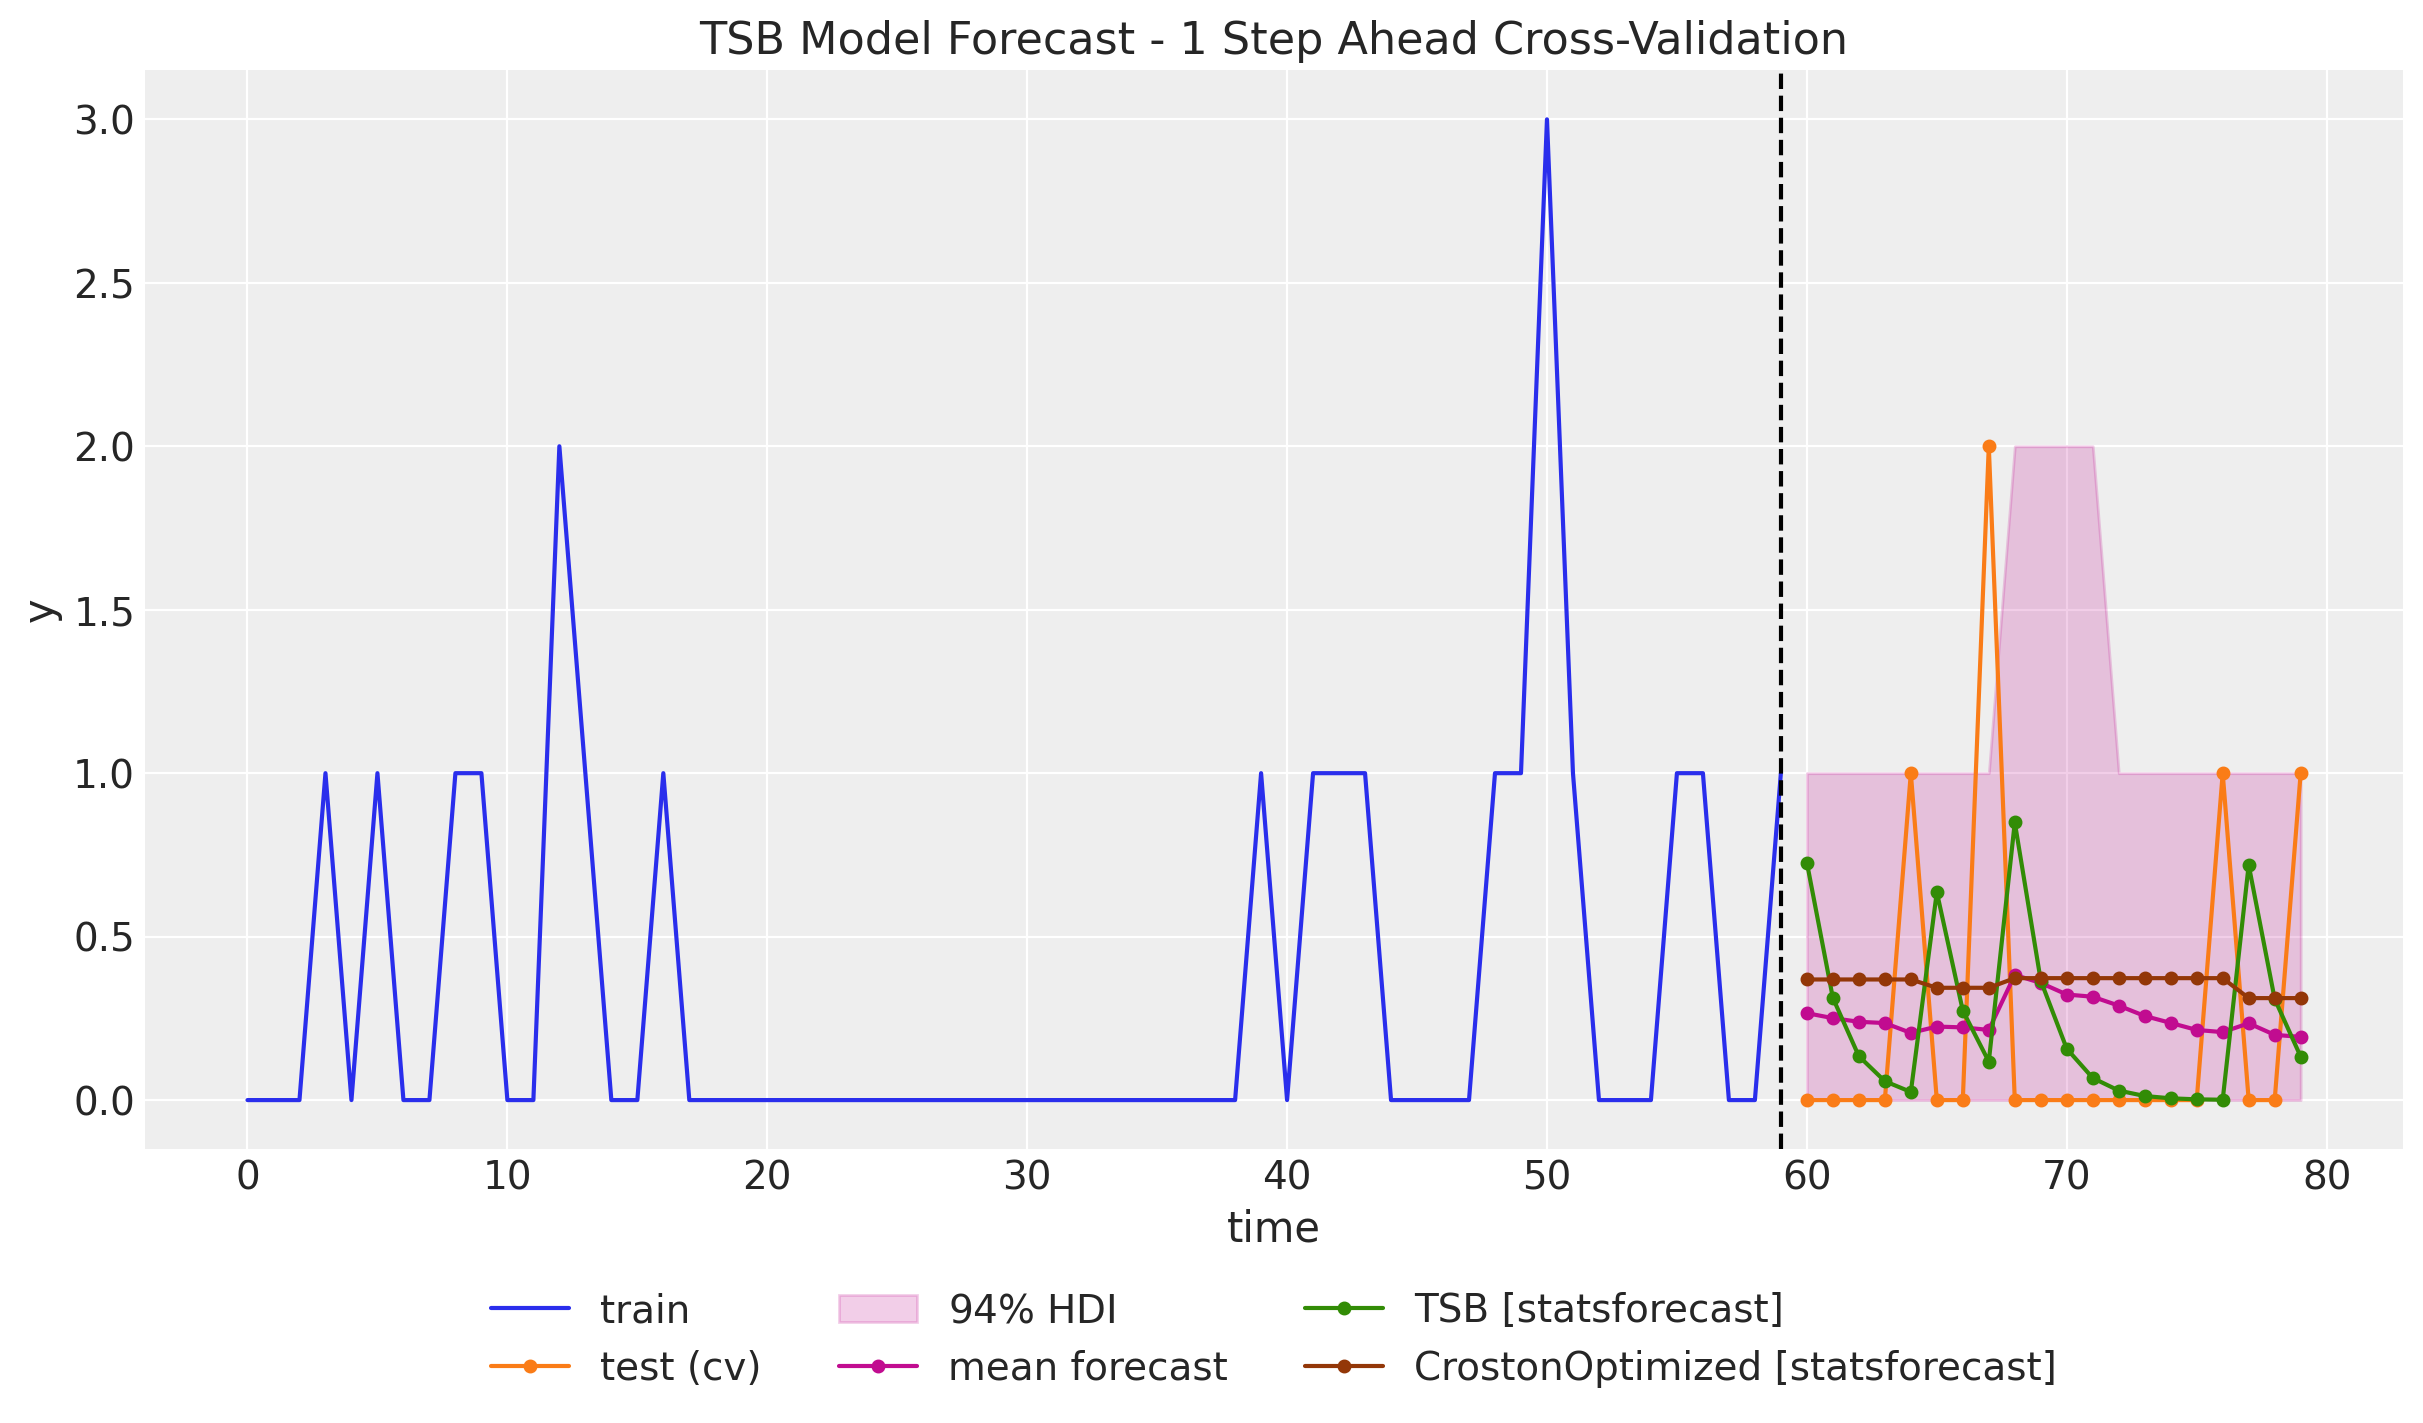

In [103]:
fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, marker="o", markersize=4, color="C1", label="test (cv)")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
az.plot_hdi(
    x=t_test,
    y=forecast_cv["ts_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": "$94\\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    forecast_cv["ts_forecast"].mean(dim=("chain", "draw")),
    marker="o",
    markersize=4,
    color="C3",
    label="mean forecast",
)
ax.plot(
    t_test,
    sf_cv["TSB"],
    color="C2",
    marker="o",
    markersize=4,
    label="TSB [statsforecast]",
)
ax.plot(
    t_test,
    sf_cv["CrostonOptimized"],
    marker="o",
    markersize=4,
    color="C4",
    label="CrostonOptimized [statsforecast]",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)
ax.set(
    xlabel="time",
    ylabel="y",
    title="TSB Model Forecast - 1 Step Ahead Cross-Validation",
)

We clearly see the decaying forecast as the training set increases with zero values. We also see how the forecast jumps as we have a non-zero demand. This is a clear advantage of the TSB method over the Croston's method for many applications as we do not want to forecast a non-zero for ever in the future even if we see an unreasonable amount of zeros.